# Named Entity Recognition (NER) for Genetic and Clinical Entities

##### Note: This exercise is part of chapter 7 in the book "Applied Machine Learning for Healthcare and Lifesciences on AWS". Make sure you have completed the steps as outlined in the prerequists section and the initial steps in the section "Building a genomic and clinical named entity recognition (NER) application" of chapter 7 to successfully complete this exercise. 

The purpose of this exercise is to create an NER applicaiton that can extract genetic and clinical entities from unstructured text. The source of this text is a Breast cancer Pathology report that we have downloaded from the TCGA portal and uploaded it on S3. In this exercise, we will use Amazon Textract to extract text from multiple pages of the test report. We will then pass the lines of text to a pre trained transformer model from the hugging face hub hosted on Sagemaker realtime endpoint. Simultaneously, we ill also pass the same lines of text to Amazon Comprehend Medical to detect Clinical entities. We will then combine the entities detected by both models to get our final result. Here is a diagram that explains this workflow:

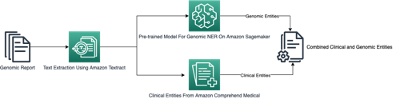


Lets begin by making sure we have the latest version of Sagemaker installed on our notebook. 




In [1]:
!pip install "sagemaker>=2.48.0" --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.7/542.7 KB 6.1 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
  Created wheel for sagemaker: filename=sagemaker-2.99.0-py2.py3-none-any.whl size=756462 sha256=1d89e7addcc06375b6d9c6a2be5c3c827f17b3dd3f2db9d6d3bf61cd7f9313f6
  Stored in directory: /root/.cache/pip/wheels/19/d5/bb/c0cf597c6d80fb0cd6926e24fbad408e19387218a0e28dff60
Successfully built sagemaker
  Attempting uninstall: sagemaker
    Found existing installation: sagemaker 2.98.0
    Uninstalling sagemaker-2.98.0:
      Successfully uninstalled sagemaker-2.98.0
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


### Deploying NER model from Huggingface Hub on Sagemaker
Next, we will import the Sagemaker huggingface library and setup some environment variables. Huggingface allows us to deploy models on Sagemaker directly from the Huggingface hub. You need to define two environemnt variables to achieve this:
1. HF_MODEL_ID: this is the model ID in the huggingface hub. In our case, we are using the model alvaroalon2/biobert_genetic_ner
2. HF_TASK: This environemnt variable defines what task you would like the model to perform. In our case, NER is a type of token classification task. 

Once you have defined these environment variables, you can create a Huggingface model as shown below. 

In [2]:
from sagemaker.huggingface.model import HuggingFaceModel
import sagemaker 

role = sagemaker.get_execution_role()


hub = {'HF_MODEL_ID':'alvaroalon2/biobert_genetic_ner','HF_TASK':'token-classification'}


huggingface_model = HuggingFaceModel(
   env=hub,
   role=role, 
   transformers_version="4.17.0",
   pytorch_version="1.10.2",
   py_version="py38"
)

Now we are ready to deploy our model. Running the code below creates a realtime endpoint on sagemaker hosting our model.

In [4]:
# deploy model to SageMaker Inference
predictor = huggingface_model.deploy(
   initial_instance_count=1,
   instance_type="ml.m5.xlarge"
)

-----!

##### Note: Make sure the model is successfully deployed before proceeding.

Let us now test our model by using some sample text. Notice the parameter aggregation_strategy in the predict method which allows us to get grouped entities in our text instead of individual tokens. Lets run the cell below and examine the output. 

In [7]:
input= {"inputs":"HER2 gene is known to cause breast cancer. A2M gene is known for pancreatic cancer",
                  "parameters": {'aggregation_strategy':"simple"}}

predictor.predict(input)

[{'entity_group': 'GENETIC',
  'score': 0.9998764395713806,
  'word': 'HER2 gene',
  'start': 0,
  'end': 9},
 {'entity_group': 'GENETIC',
  'score': 0.9999405741691589,
  'word': 'A2M gene',
  'start': 43,
  'end': 51}]

As shown in the output above, the model is able to detect HER2 gene and A2M gene correctly from the input text. 

We are now ready to extract text from our genomic test report using Amazon Textract. 

### Using Textract to extract text from genomic test report

Amazon Textract makes it easy to extract text from PDF documents. It works both in synchrnous and asynchronous modes. In a multipage document, it is recommended we use the asynchronous API. The output of the job will have metadata from which we can identify and extract text in each page of the test report. 

Lets begin by defining some funcitons. 

In [8]:
def start_job(client, s3_bucket_name, object_name):
    response = None
    response = client.start_document_text_detection(
        DocumentLocation={
            'S3Object': {
                'Bucket': s3_bucket_name,
                'Name': object_name
            }})

    return response["JobId"]


def is_job_complete(client, job_id):
    time.sleep(1)
    response = client.get_document_text_detection(JobId=job_id)
    status = response["JobStatus"]
    print("Job status: {}".format(status))

    while(status == "IN_PROGRESS"):
        time.sleep(1)
        response = client.get_document_text_detection(JobId=job_id)
        status = response["JobStatus"]
        print("Job status: {}".format(status))

    return status


def get_job_results(client, job_id):
    pages = []
    time.sleep(1)
    response = client.get_document_text_detection(JobId=job_id)
    pages.append(response)
    print("Resultset page received: {}".format(len(pages)))
    next_token = None
    if 'NextToken' in response:
        next_token = response['NextToken']

    while next_token:
        time.sleep(1)
        response = client.\
            get_document_text_detection(JobId=job_id, NextToken=next_token)
        pages.append(response)
        print("Resultset page received: {}".format(len(pages)))
        next_token = None
        if 'NextToken' in response:
            next_token = response['NextToken']

    return pages

Lets now define the path to our PDF report file on S3. Input the S3 bucket name and the document name in the code bellow between the double quotes. for example, if your file name is xyz.pdf is in bucket ABC and inside a folder efg, you can put the following in the code:
s3_bucket_name = "ABC"
document_name = "efg/xyz.pdf"

In [9]:
import boto3
import time
s3_bucket_name = "" #Enter the bucket name here
document_name = "" # Enter the path to the PDF file here
region = boto3.Session().region_name
client = boto3.client('textract', region_name=region)

The code below will call the Textract start_document_text_detection API on the PDF file. 

In [10]:
job_id = start_job(client, s3_bucket_name, document_name)
print("Started job with id: {}".format(job_id))
if is_job_complete(client, job_id):
    response = get_job_results(client, job_id)

Started job with id: da42856def66b523206faa99b2f883dcd0f34d65eb9b494af29d86e367e7ee36
Job status: IN_PROGRESS
Job status: IN_PROGRESS
Job status: IN_PROGRESS
Job status: IN_PROGRESS
Job status: IN_PROGRESS
Job status: IN_PROGRESS
Job status: IN_PROGRESS
Job status: IN_PROGRESS
Job status: IN_PROGRESS
Job status: IN_PROGRESS
Job status: IN_PROGRESS
Job status: IN_PROGRESS
Job status: SUCCEEDED
Resultset page received: 1
Resultset page received: 2
Resultset page received: 3


Once the job completes, we are now ready to parse out the text from it and detect the entities. Before doing that, lets define two functions to detect genetic and clinical entities. The first one calls our deployed model on sagemaker and the other one calls Amazon Comprehend Medical

In [11]:
def detect_clinical_entities(data):
    entities =  comprehend_medical.detect_entities(Text=data)
    for entity in entities["Entities"]:
        print("- {}".format(entity["Text"]))
        print ("   Type: {}".format(entity["Type"]))
        print ("   Category: {}".format(entity["Category"]))
        if(entity["Traits"]):
            print("   Traits:")
            for trait in entity["Traits"]:
                print ("    - {}".format(trait["Name"]))
        print("\n")

def detect_genetic_entities(data):
    entities=predictor.predict(data)
    for entity in entities:
        print("- {}".format(entity["word"]))
        print ("   Type: {}".format(entity["entity_group"]))
        print("\n")

The code block below will loop throguh all the extracted text lines from Textract and send them to Sagemaker model as well as Amazon Comprehend Medical. You can see the results of the entity extraction in the output. You can use this information to generate an entity report, store the entities in a Database or integrate these entities with the patient's history in an EHR system. 

In [12]:
comprehend_medical = boto3.client('comprehendmedical')
print("*****ENTITY EXTRACTION REPORT*****")
for result_page in response:
    for item in result_page["Blocks"]:
        if item["BlockType"] == "LINE":
            detect_clinical_entities(item["Text"])
            detect_genetic_entities({"inputs":item["Text"], "parameters": {'aggregation_strategy':"simple"}})

*****ENTITY EXTRACTION REPORT*****
- LEFT
   Type: DIRECTION
   Category: ANATOMY


- BREAST
   Type: SYSTEM_ORGAN_SITE
   Category: ANATOMY


- Estrogen Receptor
   Type: GENETIC


- Progesterone Receptor
   Type: GENETIC


- Her2neu
   Type: GENETIC


- immunoperoxidase panel
   Type: TEST_NAME
   Category: TEST_TREATMENT_PROCEDURE


- immunoperoxidase
   Type: GENETIC


- cleared
   Type: DX_NAME
   Category: MEDICAL_CONDITION
   Traits:
    - NEGATION


- U.S.
   Type: ADDRESS
   Category: PROTECTED_HEALTH_INFORMATION


- 1988
   Type: DATE
   Category: PROTECTED_HEALTH_INFORMATION


- laboratory testing
   Type: TEST_NAME
   Category: TEST_TREATMENT_PROCEDURE


- Monoclonal antibodies
   Type: TEST_NAME
   Category: TEST_TREATMENT_PROCEDURE


- PgR636
   Type: TEST_NAME
   Category: TEST_TREATMENT_PROCEDURE


- SP1
   Type: GENETIC


- PgR636
   Type: GENETIC


- LSAB immunohistochemical assay
   Type: TEST_NAME
   Category: TEST_TREATMENT_PROCEDURE


- estrogen
   Type: TEST_NAME

You are now done with this exercise! 
##### Note: Make sure you delete the Sagemaker endpoint using the code below to avoid incurring charges. 

In [13]:
# # delete endpoint
# predictor.delete_endpoint()